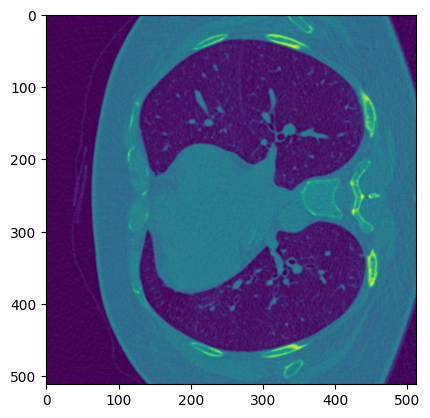

In [41]:
## THIS CELL IS WORK IN PROGRESS ! XD
from monai.transforms import (
    LoadImaged,
    Compose,
    EnsureChannelFirstd,
    ScaleIntensityd,
    RandRotate90d,
)
from monai.data import PILReader
import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt

imgs = sorted(glob(os.path.join("data", "imgs", "*.png")))[:20]
masks = sorted(glob(os.path.join("data", "masks", "*.png")))[:20]

a = [{"img": img, "mask": mask} for img, mask in zip(imgs, masks)]
transform = Compose(
    [
        LoadImaged(
            keys=["img", "mask"],
            image_only=True,
            ensure_channel_first=True,
            reader=PILReader(converter=lambda image: image.convert("L")),
            dtype=np.float32,
        ),
        RandRotate90d(
            keys=["img", "mask"], prob=0.5, spatial_axes=(0, 1)
        ),  # ONLY IN TRAINING DATASET
    ]
)
res = transform(a)

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# from unet import Unet
import gc
from tqdm import trange
from monai.networks.nets import UNet
from monai.losses import DiceLoss

gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lr = 0.001
# TODO: 2000 epochs
nepochs = 200
bs = 8
# n = 500

# model = Unet(input_channel=1).to(device)
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = DiceLoss(sigmoid=True)

d = np.load("d.npy", allow_pickle=True).item()
imgs = d["imgs"]
masks = d["masks"]

# Normalize to [0, 255]
imgs = torch.tensor(
    np.round(
        (imgs - imgs.min(axis=(1, 2))[:, None, None])
        / (imgs.max(axis=(1, 2)) - imgs.min(axis=(1, 2)))[:, None, None]
        * 255
    )
).float()
masks = torch.tensor(masks).long()

imgs = imgs
masks = masks
n = len(imgs)

# Add one color channel dimension to all the images
imgs = imgs.unsqueeze(1)
masks = masks.unsqueeze(1)

train_size = int(0.7 * n)
val_size = int(0.2 * n)
test_size = n - train_size - val_size
train_size += n - (train_size + val_size + test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    list(zip(imgs, masks)),
    [train_size, val_size, test_size],
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=bs, shuffle=True
)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=bs, shuffle=False
)

train_losses = []
val_losses = []
for epoch in (pbar := trange(nepochs)):
    model.train()
    train_loss = 0.0
    for i, (img, mask) in enumerate(train_dataloader):
        img, mask = img.to(device), mask.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pbar.set_description(
            f"Epoch {epoch+1}/{nepochs}, iteration {i+1}/{len(train_dataloader)}, loss: {loss.item()}"
        )
    train_losses.append(train_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    for i, (img, mask) in enumerate(val_dataloader):
        img, mask = img.to(device), mask.to(device)
        output = model(img)
        loss = criterion(output, mask)
        val_loss += loss.item()
        pbar.set_description(
            f"Epoch {epoch+1}/{nepochs}, iteration {i+1}/{len(val_dataloader)}, loss: {loss.item()}"
        )
    val_losses.append(val_loss / len(val_dataloader))

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), "./model-monai-200epoch-1500img.pth")

In [ ]:
import torch
from monai.networks.nets import UNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

model.load_state_dict(torch.load("./model-monai-200epoch-1500img.pth"))

In [ ]:
import torch
import matplotlib.pyplot as plt
from monai.metrics import DiceMetric, compute_iou


plt.set_cmap("gray")

model.eval()

dices = []
ious = []
rocs = []

with torch.no_grad():
    for i, (img, mask) in enumerate(test_dataloader):
        img, mask = img.to(device), mask.to(device)
        output = model(img)
        output[output >= 0.5] = 1
        output[output < 0.5] = 0
        dice_coeff = DiceMetric()(output, mask).mean(dim=0)
        iou = compute_iou(output, mask).mean(dim=0)
        if i == 4:
            plt.imshow(mask[0, 0].cpu().numpy(), cmap="gray")
            plt.imshow(output[0, 0].cpu().numpy(), cmap="jet", alpha=0.5)
            plt.show()
        dices.append(dice_coeff.item())
        ious.append(iou.item())


print(np.argmax(dices), np.argmin(dices))
print(f"Average iou: {(sum(ious) / len(ious)):.2f}")
print(f"Average dice coefficient: {(sum(dices) / len(dices)):.2f}")
plt.scatter(np.arange(len(dices)), dices, s=3, c="red")
plt.xlabel("Test batch")
plt.ylabel("Mean dice coefficient")